### Source
Example from @bwengals
https://discourse.pymc.io/t/coregionalization-model-for-two-separable-multidimensional-gaussian-process/2550/4

### NOTES:

- Using find_MAP: seems not correct
- Using trace seems alright

TODOS:
    
- Try to using LatentKron, or Kronecker

In [114]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

### generate and then plot the data

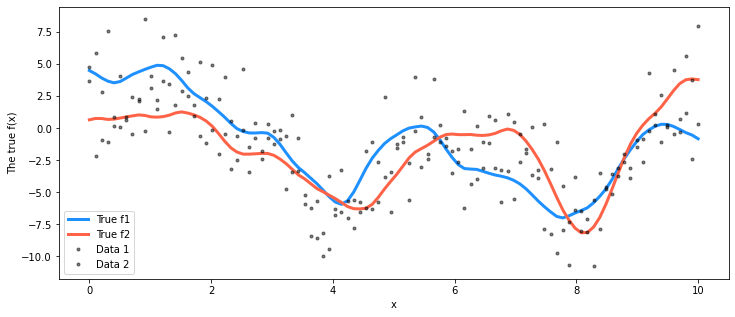

In [100]:
n = 100 
x = np.linspace(0, 10, n)[:, None] 

# true covariance function and its true parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)
mean_func = pm.gp.mean.Zero()

# two samples from the same gaussian process
f_true1 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()
f_true2 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()


sigma_true = 2.0
f1 = 0.5*f_true1 - 1.0*f_true2
f2 = 1.0*f_true1 + 0.2*f_true2
y1 = f1 + sigma_true * np.random.randn(n)
y2 = f2 + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(x, f1, "dodgerblue", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_xlabel("x"); ax.set_ylabel("The true f(x)"); plt.legend();

### Format the data for the coregionalized GP

In [101]:
x.shape, y1.shape, y2.shape

((100, 1), (100,), (100,))

In [102]:
xx = np.concatenate((x, x), axis=0)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((y1, y2))
X.shape, y.shape

((200, 2), (200,))

### pymc model

In [103]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_7725/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))


### MAP estimate and generate some predictions

In [104]:
with model:
    mp = pm.find_MAP()

In [105]:
mp

{'ell_log__': array(1.38629436),
 'eta_log__': array(1.38629436),
 'W': array([[-1.30653407,  0.07638048],
        [ 0.36723181,  1.23289919]]),
 'kappa_log__': array([0.40546511, 0.40546511]),
 'sigma_log__': array(1.09861229),
 'ell': array(4.),
 'eta': array(4.),
 'kappa': array([1.5, 1.5]),
 'sigma': array(3.)}

In [106]:
x_new = np.linspace(0, 20, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [107]:
x_new.shape, xx_new.shape, idx2.shape, X_new.shape

((200, 1), (400, 1), (400, 1), (400, 2))

In [108]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'])

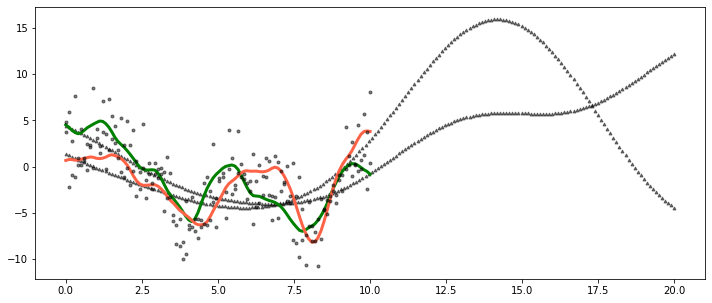

In [109]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = pred_samples.posterior_predictive["f_pred"].squeeze().values
# plot_gp_dist(ax, f_pred[:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
# plot_gp_dist(ax, f_pred[200:], X_new[200:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X_new[:200,0], f_pred[:200], '^k', ms=3, alpha=0.5, label="Data 1");
ax.plot( X_new[200:,0], f_pred[200:], '^k', ms=3, alpha=0.5, label="Data 2");

ax.plot(x, f1, "green", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");

### Using trace

In [111]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_7725/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))


In [112]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 161 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 7min 53s, sys: 13min 22s, total: 21min 16s
Wall time: 2min 43s


In [117]:
ell_true, eta_true, sigma_true

(1.0, 3.0, 2.0)

In [121]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.119,2.507,-3.959,4.654,0.246,0.174,110.0,291.0,NaN
"W[0, 1]",0.091,2.209,-4.096,3.678,0.195,0.138,141.0,406.0,NaN
"W[1, 0]",0.218,2.763,-4.335,4.972,0.263,0.186,118.0,230.0,NaN
"W[1, 1]",0.094,2.667,-4.676,4.759,0.248,0.176,122.0,198.0,NaN
ell,0.788,0.104,0.576,0.959,0.006,0.004,314.0,299.0,NaN
eta,1.280,0.496,0.529,2.213,0.046,0.034,142.0,225.0,NaN
kappa[0],1.323,1.117,0.054,3.310,0.077,0.054,85.0,81.0,NaN
kappa[1],1.426,1.116,0.126,3.404,0.060,0.042,184.0,94.0,NaN
sigma,2.116,0.119,1.909,2.340,0.008,0.005,252.0,226.0,NaN


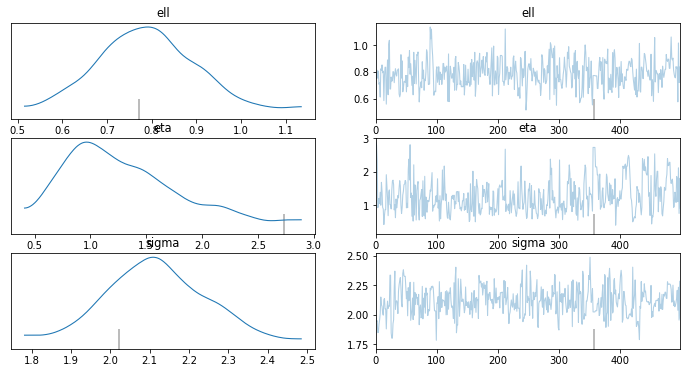

In [118]:
az.plot_trace(gp_trace, var_names=["ell", "eta", "sigma"]);

In [119]:
x_new = np.linspace(0, 20, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


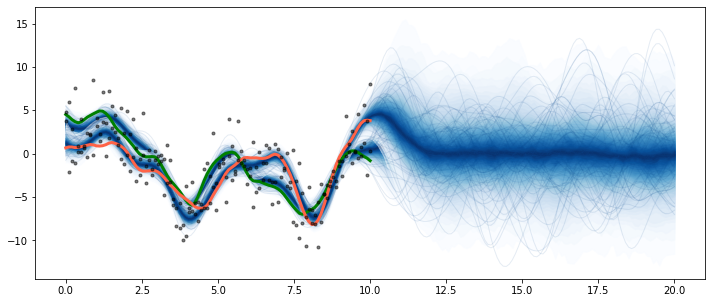

In [120]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
plot_gp_dist(ax, f_pred[:,200:], X_new[200:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)

# ax.plot(X_new[:200,0], f_pred[:,:200], '^k', ms=3, alpha=0.5, label="Data 1");
# ax.plot( X_new[200:,0], f_pred[:,200:], '^k', ms=3, alpha=0.5, label="Data 2");

ax.plot(x, f1, "green", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");

### Using LatentKron

In [110]:
from pymc.math import kronecker
import aesara.tensor as at

In [70]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), initval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    
    B = at.dot(W, W.T) + at.diag(kappa)
    
    cov_func = lambda x: kronecker(B, cov(x))
    #coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    #cov_func = coreg * cov
    #cov_func2 = pm.gp.cov.Kron([B, cov])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
ERROR (aesara.graph.opt): Optimization failure due to: constant_folding
ERROR (aesara.graph.opt): node: Assert{msg=Could not broadcast dimensions}(TensorConstant{400}, TensorConstant{False})
ERROR (aesara.graph.opt): TRACEBACK:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/graph/opt.py", line 1850, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/graph/opt.py", line 1055, in transform
    return self.fn(fgraph, node)
  File "/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 2955, 

AssertionError: Could not broadcast dimensions

In [68]:
type(cov_func)

aesara.tensor.var.TensorVariable

In [59]:
type(B)

aesara.tensor.var.TensorVariable

In [60]:
B.eval()

array([[ 5.81354982, -2.56528296],
       [-2.56528296,  2.53442601]])

In [61]:
X.shape, y.shape

((200, 2), (200,))

In [62]:
cov(X).eval().shape

(200, 200)

In [63]:
coreg(X).eval().shape

(200, 200)

In [64]:
cov_func(X).eval().shape

TypeError: 'TensorVariable' object is not callable

In [13]:
x_new = np.linspace(0, 20, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f09681d8f70>
Traceback (most recent call last):
  File "/home/danh/miniconda3/envs/pymc-dev-py39/lib/python3.9/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


NameError: name 'gp_trace' is not defined

In [30]:


with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    cov_func = pm.gp.cov.Kron([coreg, cov])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_7725/2153871691.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


IndexError: index 0 is out of bounds for axis 1 with size 0

In [20]:
X.shape

(200, 2)

In [83]:
kappa.eval()

array([0.48482749, 3.59198451])

In [98]:

with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    gp = pm.gp.MarginalKron(cov_funcs=[coreg, cov])
    
    Xs = [X, W.eval()]
   
    sigma = pm.HalfNormal("sigma", sigma=3)
    y_ = gp.marginal_likelihood("y", Xs=Xs, y=y, sigma=sigma)

/tmp/ipykernel_7725/3196179282.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))


ValueError: Length of y (200) must match length of cartesian product of Xs (400)

In [91]:
coreg(X).eval().shape, cov(X).eval().shape

((200, 200), (200, 200))

In [85]:
f.eval().shape

(400,)

In [86]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: Input dimension mismatch. (input[3].shape[0] = 200, input[4].shape[0] = 400)
Apply node that caused the error: Elemwise{Composite{Switch(i0, ((i1 + (i2 * sqr(((i3 - i4) / i5)))) - i6), i7)}}[(0, 4)](Elemwise{gt,no_inplace}.0, TensorConstant{(1,) of -0..5332046727}, TensorConstant{(1,) of -0.5}, y_{[  3.71102...02300133]}, Reshape{1}.0, InplaceDimShuffle{x}.0, Elemwise{log,no_inplace}.0, TensorConstant{(1,) of -inf})
Toposort index: 42
Inputs types: [TensorType(bool, (1,)), TensorType(float64, (1,)), TensorType(float64, (1,)), TensorType(float64, (200,)), TensorType(float64, (None,)), TensorType(float64, (1,)), TensorType(float64, (1,)), TensorType(float32, (1,))]
Inputs shapes: [(1,), (1,), (1,), (200,), (400,), (1,), (1,), (1,)]
Inputs strides: [(1,), (8,), (8,), (8,), (8,), (8,), (8,), (4,)]
Inputs values: [array([ True]), array([-0.91893853]), array([-0.5]), 'not shown', 'not shown', array([7.60290533]), array([2.02853045]), array([-inf], dtype=float32)]
Outputs clients: [[Sum{acc_dtype=float64}(sigma > 0)]]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.